## **Risks and Portfolio Optimization**
In this project we will be focused on the 10 largest companies listed on the London Stock Exchange (LSE) by market capitalization, intending to understand how they can be integrated into an optimal investment portfolio, whose optimization will be carried out through Monte Carlo Simulation and PyPortfolioOpt Optimizer. The aim is also to compare the performance of each portfolio over time, namely in terms of tail risk, by estimating Value at Risk (VaR) and Conditional Value at Risk (CVaR or Expected Shortfall) for different time frames.


Aleksandr K.

### **1. Importing libraries**

In [2]:
import yfinance as yf
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import seaborn as sns

### **2. Loading and pre-processing the data**

In [9]:
# Define a list of tickers
tickers = ['SHEL', 'HSBC', 'AZN', 'UL', 'DEO', 'BP', 'GSK', 'RIO', 'AON', 'LIN']

# Function to retrieve company names from tickers
def get_company_names(tickers):
    company_names = []
    for ticker in tickers:
        try:
            stock_info = yf.Ticker(ticker).info
            company_name = stock_info['longName']
            company_names.append(company_name)
        except:
            company_names.append(None)
    return company_names

# Call the function to get company names
company_names = get_company_names(tickers)

# Print the list of company names
print(company_names)

['Shell plc', 'HSBC Holdings plc', 'AstraZeneca PLC', 'Unilever PLC', 'Diageo plc', 'BP p.l.c.', 'GSK plc', 'Rio Tinto Group', 'Aon plc', 'Linde plc']


In [46]:
# Stock data extraction from Yahoo Finance. 
# Note: to calculate stock betas, we added FTSE 100 index to the dataset

prices = yf.download(tickers, start="2012-01-31", end="2023-04-04")["Close"]
market_price = yf.download('^FTSE', start="2012-01-31", end="2023-02-01")["Close"]
prices = pd.concat([market_price,prices,], axis=1)

# Converting datetime format
prices.reset_index(inplace=True)
prices['Date'] = prices['Date'].dt.strftime('%Y/%m/%d')
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [47]:
# Renaming columns
prices.columns = ['FTSE 100'] + prices.columns.tolist()[1:]
prices.columns = company_names + prices.columns.tolist()[:1]

# Filling missing values with interpolation
prices = prices.interpolate(method="nearest")
prices.tail().round(1)

# Exporting prices to csv (for future uses)
prices.to_csv('Companies_Prices.csv')

In [48]:
# Calculating simple price returns
returns = prices.pct_change().dropna()

# Splitting returns
stock_returns = returns.iloc[:,:-1]
market_returns = pd.Series(returns['FTSE 100'])

### **3. Analysis of simple and cumulative returns**

#### Daily returns

In [13]:
# Descriptive statistics of daily returns
import scipy.stats as stats
summary = round(stock_returns.describe().T, 4)
summary['Skew'] = stats.skew(stock_returns._get_numeric_data()).round(4)
summary['Kurt'] = stats.kurtosis(stock_returns._get_numeric_data()).round(4)
summary = summary.drop('count', axis=1)
summary

mean     std     min     25%     50%     75%     max  \
Shell plc          0.0002  0.0097 -0.1087 -0.0044  0.0003  0.0049  0.0905   
HSBC Holdings plc  0.0007  0.0137 -0.1670 -0.0052  0.0008  0.0072  0.1413   
AstraZeneca PLC    0.0005  0.0151 -0.1491 -0.0067  0.0002  0.0078  0.1216   
Unilever PLC       0.0001  0.0189 -0.1910 -0.0081  0.0000  0.0081  0.2161   
Diageo plc         0.0003  0.0128 -0.1049 -0.0060  0.0002  0.0065  0.1150   
BP p.l.c.          0.0000  0.0124 -0.1104 -0.0060  0.0000  0.0067  0.0944   
GSK plc            0.0000  0.0151 -0.1025 -0.0072  0.0000  0.0074  0.1037   
Rio Tinto Group    0.0005  0.0137 -0.1028 -0.0064  0.0002  0.0072  0.1169   
Aon plc            0.0003  0.0210 -0.0986 -0.0112  0.0002  0.0115  0.1579   
Linde plc          0.0001  0.0185 -0.1717 -0.0078  0.0000  0.0082  0.1968   

                     Skew     Kurt  
Shell plc         -0.6177  11.5363  
HSBC Holdings plc -0.1730  17.5670  
AstraZeneca PLC   -0.1647  10.8276  
Unilever PLC       0.0351  16.3187  
Diageo plc         0.2649   9.2613  
BP p.l.c.         -0.3055   8.1861  
GSK plc            0.0243   5.5523  
Rio Tinto Group    0.1534   6.9861  
Aon plc            0.1736   3.2738  
Linde plc         -0.3422  15.7708

- Companies such as Shell, HSBC, AstraZeneca, BP, and Linde exhibit a negatively skewed distribution, indicating that their returns are concentrated more towards the right tail of the distribution, with a longer tail on the left side. This suggests that investors in these companies may experience frequent small gains but also some large losses, as the distribution of returns is skewed towards the negative side.

- The distribution of all stocks is characterized by heavy tails or leptokurtic distribution, with some stocks exhibiting a kurtosis value that exceeds 10.

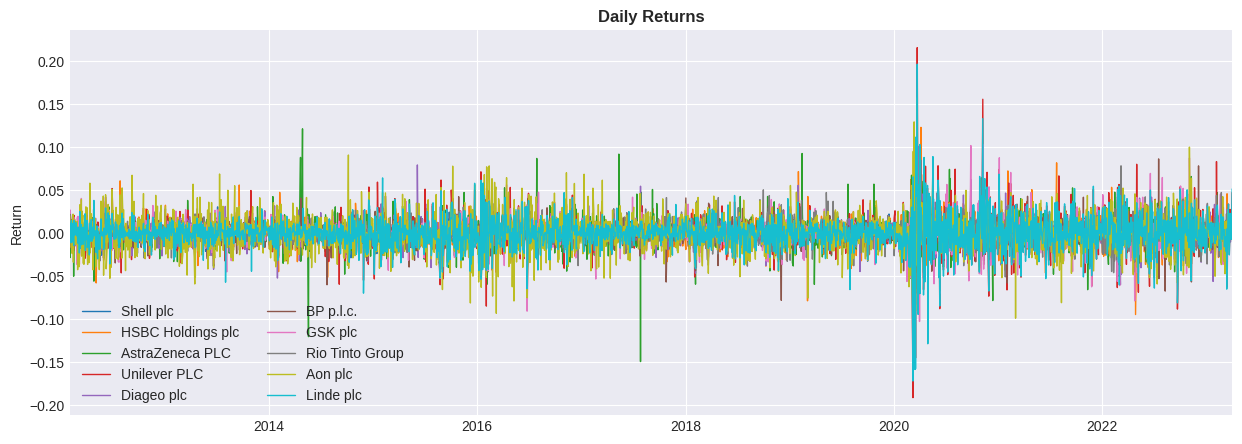

In [14]:
# Line plot function
def line_plot(data,legend_loc, legend_ncol, title, ylabel):
    plt.figure(figsize=(15,5))
    for col in data:
        plt.plot(data.index, data[col], marker='', linewidth=1, label=col)
        plt.legend(loc=legend_loc, ncol=legend_ncol)
        plt.margins(x=0)
        plt.title(title, weight='bold')
        plt.ylabel(ylabel)
    plt.show()

# Plotting daily returns
line_plot(data=stock_returns, legend_loc='lower left', legend_ncol=2, 
            title='Daily Returns', ylabel='Return')

Text(0.5, 1.0, 'Daily Returns Distribution')

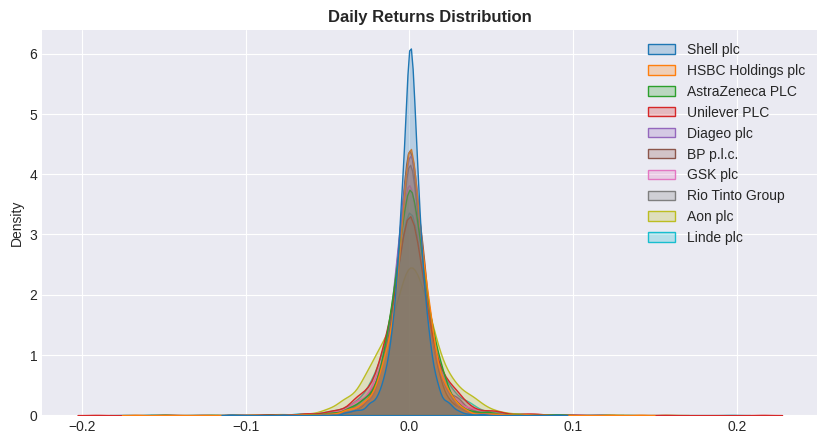

In [15]:
# Daily Returns distribution
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=stock_returns,fill=True)
plt.title('Daily Returns Distribution', weight='bold')

Aon and Unilever exhibit wider distributions, indicating higher volatility associated with these companies.

In [16]:
# Let's find minimum and maximum return dates

ret_min_max_dates = pd.DataFrame({'Min Return': stock_returns.idxmin(),
'Max Return': stock_returns.idxmax()})
ret_min_max_dates

Min Return Max Return
Shell plc         2020-03-12 2020-03-24
HSBC Holdings plc 2020-03-09 2020-03-24
AstraZeneca PLC   2017-07-27 2014-04-28
Unilever PLC      2020-03-09 2020-03-24
Diageo plc        2020-03-16 2020-03-24
BP p.l.c.         2020-03-16 2020-03-17
GSK plc           2020-04-01 2020-11-09
Rio Tinto Group   2020-03-16 2020-03-13
Aon plc           2021-03-04 2020-03-24
Linde plc         2020-03-09 2020-03-24

It seems that many of these stocks experienced their lowest and highest returns in early 2020 (the Covid-19 pandemic time), which illustrates the high volatility and financial contagion associated with that period.

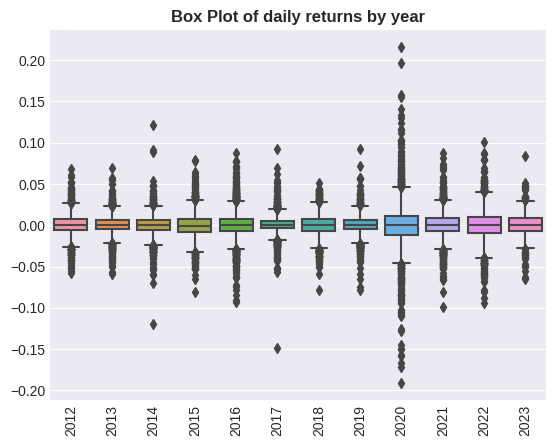

In [17]:
# now we draw the Box Plot of daily returns by year

returns_by_year = pd.melt(stock_returns.reset_index(),id_vars='Date')
returns_by_year['Year'] = pd.DatetimeIndex(returns_by_year['Date']).year
returns_by_year
ax = sns.boxplot(data = returns_by_year, x='Year',y='value')
ax.set_title('Box Plot of daily returns by year', weight='bold')
ax.set_ylabel(''), ax.set_xlabel('')
for item in ax.get_xticklabels():
    item.set_rotation(90)

The box plot of all returns grouped by year also reflects the high volatility during the first year of the pandemic, with a greater dispersion of data in 2020.

In [18]:
# Let's see some risk details

ret_stats = stock_returns.agg(['mean','std']).T
ret_stats.columns=['Return','Risk']
ret_stats['Return'] = ret_stats['Return']*252
ret_stats['Risk'] = ret_stats['Risk']*np.sqrt(252)
ret_stats['Sharpe_Ratio']=(ret_stats['Return']-0.03510)/ret_stats['Risk']
ret_stats = ret_stats.sort_values('Sharpe_Ratio', ascending=False)
ret_stats.round(3)

Return   Risk  Sharpe_Ratio
HSBC Holdings plc   0.188  0.217         0.707
Rio Tinto Group     0.130  0.218         0.437
AstraZeneca PLC     0.122  0.240         0.364
Diageo plc          0.084  0.203         0.239
Aon plc             0.066  0.333         0.092
Shell plc           0.039  0.154         0.028
Unilever PLC        0.032  0.299        -0.009
Linde plc           0.029  0.294        -0.020
GSK plc             0.012  0.240        -0.095
BP p.l.c.           0.001  0.197        -0.176

**The Sharpe Ratio** is a measure that quantifies the excess return of a stock or portfolio in relation to its standard deviation of returns.

* HSBC has the highest Sharpe ratio among the listed companies, with a value of 0.707, indicating that it provides 0.707 units of return for each unit of risk taken.
* On the other hand, Unilever, Linde, GSK, and BP have negative Sharpe ratios, suggesting that they did not generate returns higher than treasury bills during the period analyzed. This may make them less attractive to investors who aim to maximize their portfolio's adjusted returns

Text(0.5, 1.0, 'Risk-Return profile')

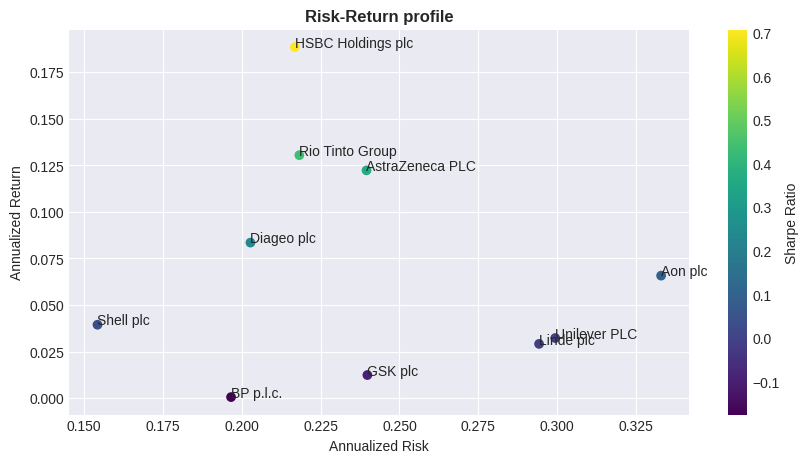

In [20]:
# Plot risk details

fig = plt.figure(figsize=(10,5))
plt.scatter(data=ret_stats,x='Risk',y='Return', c='Sharpe_Ratio', cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
texts = []
for x, y, s in zip(ret_stats['Risk'],ret_stats['Return'], ret_stats.index):
    texts.append(plt.text(x,y,s))
plt.xlabel('Annualized Risk'), plt.ylabel('Annualized Return')
plt.title('Risk-Return profile', weight='bold')

In [21]:
# Measuring stock volatility through Beta
betas = []
for i in range(len(stock_returns.columns)):
    beta = np.polyfit(market_returns, stock_returns.iloc[:,i],1)[0]
    betas.append(beta)
betas = pd.DataFrame(betas, columns=['Beta'], index=company_names)
betas = betas.sort_values('Beta',ascending=False)
betas.round(3)

Beta
Diageo plc         0.554
Aon plc            0.483
Linde plc          0.446
Unilever PLC       0.444
AstraZeneca PLC    0.440
Rio Tinto Group    0.435
BP p.l.c.          0.433
GSK plc            0.422
HSBC Holdings plc  0.351
Shell plc          0.312

The Beta coefficient is a measure of the volatility of a security or portfolio in relation to the overall systematic risk of the market. It describes how the returns of a security or portfolio respond to changes in the market. Since all of the stocks in the list have Beta coefficients less than one, it can be inferred that they have lower volatility than the overall market. This means that including any of these stocks in a portfolio would likely reduce the overall risk of the portfolio compared to excluding them.

#### Cumulative daily returns

In [22]:
# Calculation of cumulative returns, as the growth of 1 (dollar or euro, or pound) 
cum_returns = ((1 + stock_returns).cumprod()-1)*100

# Rates of change for each company share
ticker_change = cum_returns.tail(1).round(3)
ticker_change

Shell plc  HSBC Holdings plc  AstraZeneca PLC  Unilever PLC  \
Date                                                                      
2023-04-03     36.787            554.718          190.384       -13.439   

            Diageo plc  BP p.l.c.  GSK plc  Rio Tinto Group  Aon plc  \
Date                                                                   
2023-04-03     105.034    -19.286  -16.997          237.194    12.62   

            Linde plc  
Date                   
2023-04-03    -15.205

HSBC, AstraZeneca, Diageo, and Rio Tinto are notable for their significant growth, with a rate of change exceeding 100%. On the other hand, Unilever, BP, GSK, and Linde have negative values, indicating a decline or negative growth in comparison.

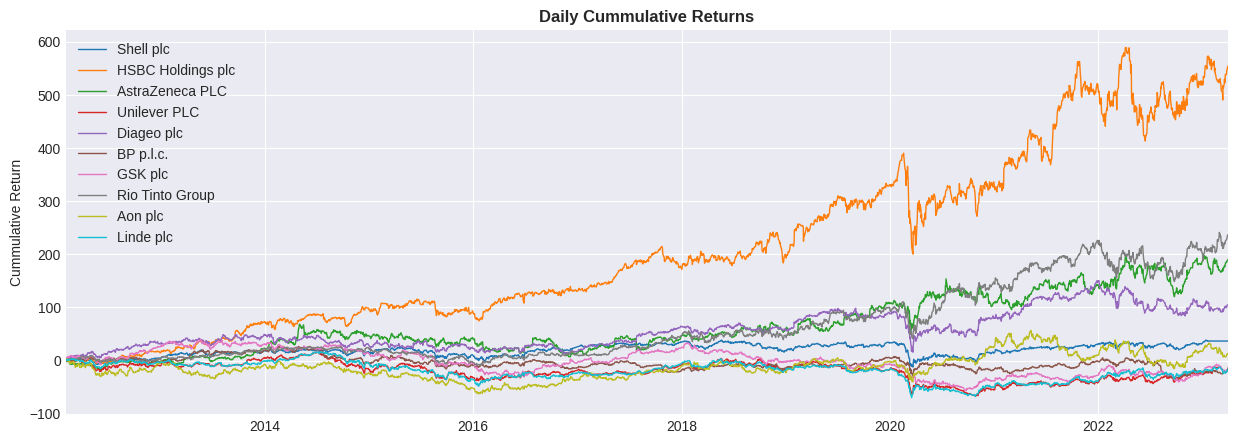

In [23]:
# Plotting daily cummulative returns
line_plot(data=cum_returns, legend_loc='upper left', legend_ncol=1,
            title='Daily Cummulative Returns', ylabel='Cummulative Return')

During the Covid-19 period, cumulative returns experienced a decline. Shell, in particular, saw a significant drop to negative values, possibly due to the sharp decrease in oil demand resulting from widespread restrictions. Other companies also exhibited similar declines during this period.

#### Correlation and Covariance matrices

Text(0.5, 1.0, 'Correlation Heatmap')

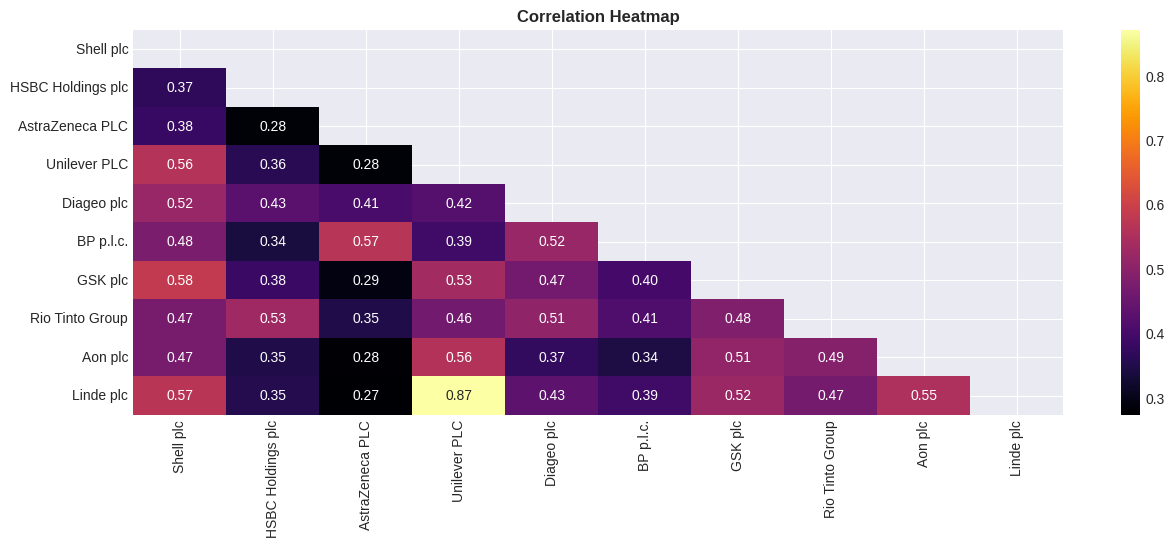

In [24]:
# Correlation Heatmap
import seaborn as sns
plt.figure(figsize=(15,5))
mask = np.triu(np.ones_like(stock_returns.corr(), dtype=bool))
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(stock_returns.corr(), mask=mask, annot=True, fmt=".02f", cmap='inferno')
plt.title('Correlation Heatmap', weight='bold')

* It is evident that Shell and Unilever exhibit strong correlations with the other stocks.
* AstraZeneca, on the other hand, appears to have the lowest correlation with the overall market.

In [25]:
# Annual Covariance matrix
cov_matrix = stock_returns.cov(numeric_only=True)*252
cov_matrix.round(4)

Shell plc  HSBC Holdings plc  AstraZeneca PLC  \
Shell plc             0.0238             0.0123           0.0140   
HSBC Holdings plc     0.0123             0.0470           0.0146   
AstraZeneca PLC       0.0140             0.0146           0.0574   
Unilever PLC          0.0259             0.0233           0.0202   
Diageo plc            0.0161             0.0189           0.0197   
BP p.l.c.             0.0144             0.0144           0.0267   
GSK plc               0.0216             0.0199           0.0167   
Rio Tinto Group       0.0159             0.0251           0.0181   
Aon plc               0.0242             0.0250           0.0221   
Linde plc             0.0258             0.0226           0.0193   

                   Unilever PLC  Diageo plc  BP p.l.c.  GSK plc  \
Shell plc                0.0259      0.0161     0.0144   0.0216   
HSBC Holdings plc        0.0233      0.0189     0.0144   0.0199   
AstraZeneca PLC          0.0202      0.0197     0.0267   0.0167   
Unilever PLC             0.0897      0.0256     0.0231   0.0384   
Diageo plc               0.0256      0.0411     0.0207   0.0226   
BP p.l.c.                0.0231      0.0207     0.0386   0.0187   
GSK plc                  0.0384      0.0226     0.0187   0.0575   
Rio Tinto Group          0.0303      0.0223     0.0176   0.0254   
Aon plc                  0.0558      0.0252     0.0226   0.0407   
Linde plc                0.0768      0.0258     0.0226   0.0368   

                   Rio Tinto Group  Aon plc  Linde plc  
Shell plc                   0.0159   0.0242     0.0258  
HSBC Holdings plc           0.0251   0.0250     0.0226  
AstraZeneca PLC             0.0181   0.0221     0.0193  
Unilever PLC                0.0303   0.0558     0.0768  
Diageo plc                  0.0223   0.0252     0.0258  
BP p.l.c.                   0.0176   0.0226     0.0226  
GSK plc                     0.0254   0.0407     0.0368  
Rio Tinto Group             0.0476   0.0357     0.0301  
Aon plc                     0.0357   0.1109     0.0539  
Linde plc                   0.0301   0.0539     0.0866

### **2. Portfolio optimization**

#### 2.1 Global Minimum Variance (GMV) and Maximum Sharpe Ratio (MSR) Portfolios

##### Portfolio Optimization via Monte Carlo Method

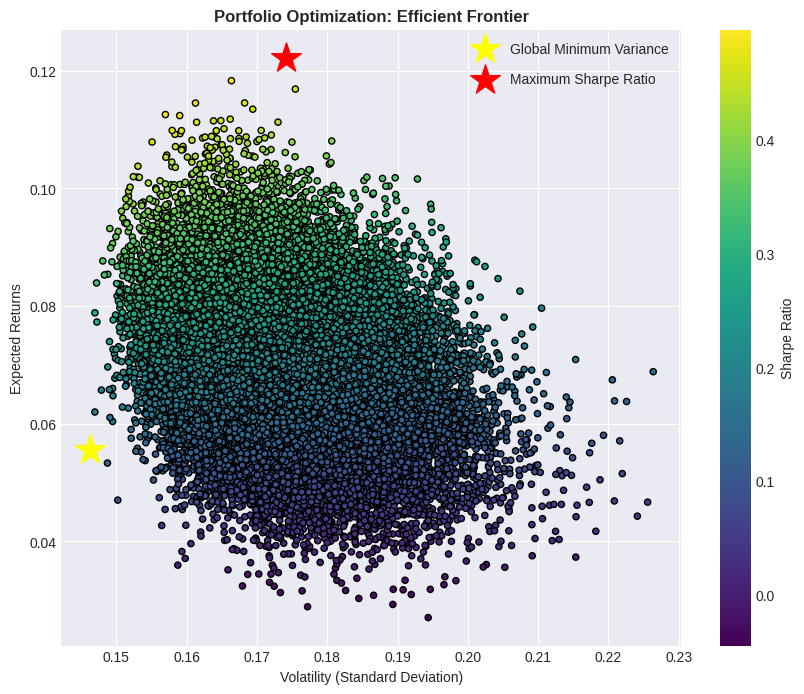

In [26]:
mean_ret = stock_returns.mean()*252
std_returns = stock_returns.std()*np.sqrt(252)

assets_num=len(tickers)
port_num=50000
port_ret=[]
port_vol=[]
port_weights=[]
sharpe_ratio=[]

for portfolio in range(port_num):
    weights = np.random.random(assets_num)
    weights /= np.sum(weights)
    ret = np.dot(weights, mean_ret)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights)))
    rf = 0.03570 # US 10y Bond Yield in 2023 as an example
    sharpe = (ret-rf)/vol
    sharpe_ratio.append(sharpe)
    port_ret.append(ret)
    port_vol.append(vol)
    port_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
port_dict = {'Returns': port_ret,
             'Volatility': port_vol,
             'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(company_names):
    port_dict[symbol] = [Weight[counter] for Weight in port_weights]

port_EF = pd.DataFrame(port_dict)

gmv_port_value = port_EF['Volatility'].min()
msr_port_value = port_EF['Sharpe Ratio'].max()

gmv_port = port_EF.loc[port_EF['Volatility'] == gmv_port_value]
msr_port = port_EF.loc[port_EF['Sharpe Ratio'] == msr_port_value]

port_EF.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Portfolio Optimization: Efficient Frontier', weight='bold')
plt.scatter(x=gmv_port['Volatility'], y=gmv_port['Returns'], c='yellow', marker='*', s=500, label='Global Minimum Variance')
plt.scatter(x=msr_port['Volatility'], y=msr_port['Returns'], c='red', marker='*', s=500, label='Maximum Sharpe Ratio')
plt.legend(labelspacing=1.2)
plt.grid(True)
plt.show()

In [27]:
# Global Minimum Variance Portfolio (GMV) 
gmv_port.round(3)

Returns  Volatility  Sharpe Ratio  Shell plc  HSBC Holdings plc  \
35402    0.056       0.146         0.136      0.332              0.088   

       AstraZeneca PLC  Unilever PLC  Diageo plc  BP p.l.c.  GSK plc  \
35402            0.032         0.034       0.042      0.297    0.025   

       Rio Tinto Group  Aon plc  Linde plc  
35402            0.117    0.022      0.011

In [28]:
# Maximum Sharpe Ratio Portfolio (MSR)
msr_port.round(3)

Returns  Volatility  Sharpe Ratio  Shell plc  HSBC Holdings plc  \
45357    0.122       0.174         0.497      0.049              0.373   

       AstraZeneca PLC  Unilever PLC  Diageo plc  BP p.l.c.  GSK plc  \
45357            0.068         0.023       0.058      0.021    0.048   

       Rio Tinto Group  Aon plc  Linde plc  
45357            0.187    0.163       0.01

##### Using PyPortfolioOpt library for optimization

PyPortfolioOpt is a library that implements portfolio optimization methods, including classical efficient frontier techniques and Black-Litterman allocation, as well as more recent developments in the field like shrinkage and Hierarchical Risk Parity, along with some novel experimental features like exponentially-weighted covariance matrices.

It is extensive yet easily extensible, and can be useful for both the casual investor and the serious practitioner. Whether you are a fundamentals-oriented investor who has identified a handful of undervalued picks, or an algorithmic trader who has a basket of strategies, PyPortfolioOpt can help you combine your alpha sources in a risk-efficient way.

Source: https://pyportfolioopt.readthedocs.io/en/latest/

In [30]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00


In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

rf = 0.03570 # see the comment about why this value is chosen
stock_prices = prices.iloc[:,:-1]
mu = expected_returns.mean_historical_return(stock_prices)
S = risk_models.sample_cov(stock_prices)
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) # Weights between 0 and 1, ie, no short-selling

# Maximun Sharpe Ratio (MSR) Portfolio
opt_msr = ef.max_sharpe(risk_free_rate=rf)
weights_msr = ef.clean_weights()
print('-----------------------------')
print("\033[1m" + "Portfolio Performance:")
print('-----------------------------')
print('Max Sharpe Portfolio:\n')
print(ef.portfolio_performance(verbose=True, risk_free_rate = rf)[:-3])

print('\nGlobal Min Variance Portfolio:\n')
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) # weights between 0 and 1, i.e., no short-selling
opt_gmv = ef.min_volatility()
weights_gmv = ef.clean_weights()
print(ef.portfolio_performance(verbose=True, risk_free_rate = rf)[:-3])

-----------------------------
Portfolio Performance:
-----------------------------
Max Sharpe Portfolio:

Expected annual return: 17.1%
Annual volatility: 20.3%
Sharpe Ratio: 0.67
()

Global Min Variance Portfolio:

Expected annual return: 5.5%
Annual volatility: 13.9%
Sharpe Ratio: 0.14
()


*Max Sharpe Portfolio:*

The expected annual return of the portfolio is 17.1%, indicating the anticipated average annual return of the portfolio over a given period.
The annual volatility of the portfolio is 20.3%, which signifies the degree of fluctuation or risk associated with the portfolio's returns on an annual basis.
The Sharpe Ratio of the portfolio is 0.67, which is a measure of risk-adjusted performance. A higher Sharpe Ratio indicates a better risk-adjusted return for the portfolio.

*Global Min Variance Portfolio:*

The expected annual return of the portfolio is 5.5%, representing the projected average annual return of the portfolio over a specific time period.
The annual volatility of the portfolio is 13.9%, which reflects the level of fluctuation or risk associated with the portfolio's returns on an annual basis.
The Sharpe Ratio of the portfolio is 0.14, which is a measure of risk-adjusted performance. A higher Sharpe Ratio indicates a better risk-adjusted return for the portfolio.

shares of stocks in portfolios

In [40]:
opt_msr

OrderedDict([('Shell plc', 0.0),
             ('HSBC Holdings plc', 0.8977662358136022),
             ('AstraZeneca PLC', 0.1022337641863978),
             ('Unilever PLC', 0.0),
             ('Diageo plc', 0.0),
             ('BP p.l.c.', 0.0),
             ('GSK plc', 0.0),
             ('Rio Tinto Group', 0.0),
             ('Aon plc', 0.0),
             ('Linde plc', 0.0)])

In [41]:
opt_gmv

OrderedDict([('Shell plc', 0.5345333831703181),
             ('HSBC Holdings plc', 0.1627570540121772),
             ('AstraZeneca PLC', 0.0641907578489919),
             ('Unilever PLC', 0.0),
             ('Diageo plc', 0.0609533587237919),
             ('BP p.l.c.', 0.1446143086681482),
             ('GSK plc', 0.0),
             ('Rio Tinto Group', 0.0329511375765727),
             ('Aon plc', 0.0),
             ('Linde plc', 0.0)])

#### 2.2 Equally-Weighted Portfolio

All stocks in the portfolio have equal weight in determining the overall portfolio value.

In [32]:
numstocks = 10
weights_ew = np.repeat(1/numstocks,numstocks)
ew_df= pd.DataFrame(weights_ew, index=ret_stats.index, columns=['EW'])

In [38]:
ew_df

EW
HSBC Holdings plc  0.1
Rio Tinto Group    0.1
AstraZeneca PLC    0.1
Diageo plc         0.1
Aon plc            0.1
Shell plc          0.1
Unilever PLC       0.1
Linde plc          0.1
GSK plc            0.1
BP p.l.c.          0.1

#### 2.3 Market Cap-Weighted Portfolio
In this portfolio, the allocation of each stock is based on its respective total market capitalization.

First, we retrieve data about total market capitalization for the selected companies

In [35]:
# Empty list to store market capitalization
market_caps = []

# Loop through each ticker
for ticker in tickers:
    # Retrieve stock information using yfinance
    stock_info = yf.Ticker(ticker).info
    # Extract market capitalization from stock information
    market_cap = stock_info['marketCap']
    market_cap = market_cap / 1e6

    # Append market capitalization to the list
    market_caps.append(market_cap)

# Print the list of market capitalizations
print("Market Capitalizations:")
for ticker, market_cap in zip(tickers, market_caps):
    print(ticker, market_cap, "mln.")

Market Capitalizations:
SHEL 210329.02656 mln.
HSBC 142794.26048 mln.
AZN 234336.550912 mln.
UL 137661.186048 mln.
DEO 106449.813504 mln.
BP 116668.448768 mln.
GSK 75162.624 mln.
RIO 109703.340032 mln.
AON 68435.37408 mln.
LIN 180234.272768 mln.


In [36]:
mcap = np.array(market_caps)
mcap_weights = mcap/sum(mcap)
mcap_df= pd.DataFrame(mcap_weights, index=ret_stats.index, columns=['MCAP'])

In [37]:
mcap_df

MCAP
HSBC Holdings plc  0.152217
Rio Tinto Group    0.103341
AstraZeneca PLC    0.169591
Diageo plc         0.099626
Aon plc            0.077038
Shell plc          0.084434
Unilever PLC       0.054396
Linde plc          0.079393
GSK plc            0.049527
BP p.l.c.          0.130437

### **3. Analysis of optimized Portfolios' Performance**
In this section, our attention will be directed towards the most recent four portfolios that have been generated: Equally-Weighted, Market-Cap Weighted, Minimum Variance and Maximum Sharpe Ratio

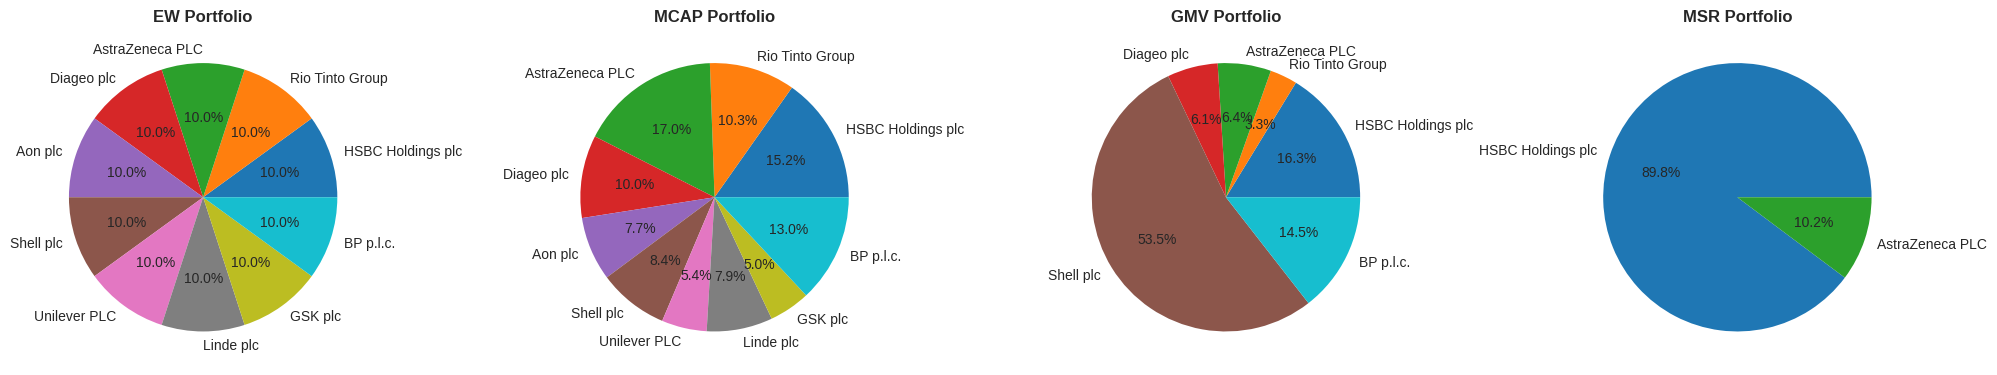

In [39]:
# Portolio weights
gmv_df = pd.DataFrame.from_dict(weights_gmv, orient='index')
gmv_df.columns = ['GMV']

msr_df = pd.DataFrame.from_dict(weights_msr, orient='index')
msr_df.columns = ['MSR']

weights_df = pd.concat([ew_df, mcap_df, gmv_df, msr_df],axis=1)

fig = plt.figure(figsize=(20,10))
colours = dict(zip(weights_df.index, plt.cm.tab10.colors[:len(weights_df.index)]))
for column,num in zip(weights_df.columns, range(len(weights_df.columns))):
    plt.subplot(1,4,num+1)
    labels, values = zip(*((key,value) for key,value in weights_df[column].items() if value>0))
    plt.pie(values, labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%')
    plt.title('{} Portfolio'.format(column), weight='bold')
    fig.tight_layout()
plt.show()

In [49]:
# Calculating portfolio returns
stock_returns = pd.concat([stock_returns,stock_returns.dot(weights_df)], axis=1)
portfolio_returns = stock_returns.iloc[:,-4:]

Text(0.5, 1.0, 'Box Plot of Daily Returns')

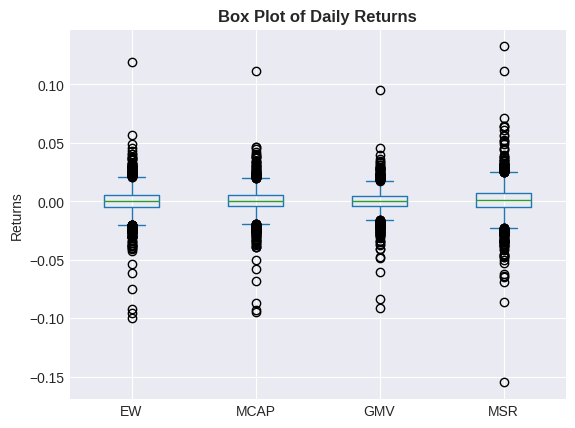

In [50]:
# Volatility Analysis
# Box plots are used to visualize the variance of each portfolio's returns
portfolio_returns.plot(kind='box', ylabel="Returns")
plt.title("Box Plot of Daily Returns", weight='bold')

As anticipated, the returns of the minimum variance portfolio exhibit less dispersion compared to the other portfolios, as evidenced by a smaller interquartile range.

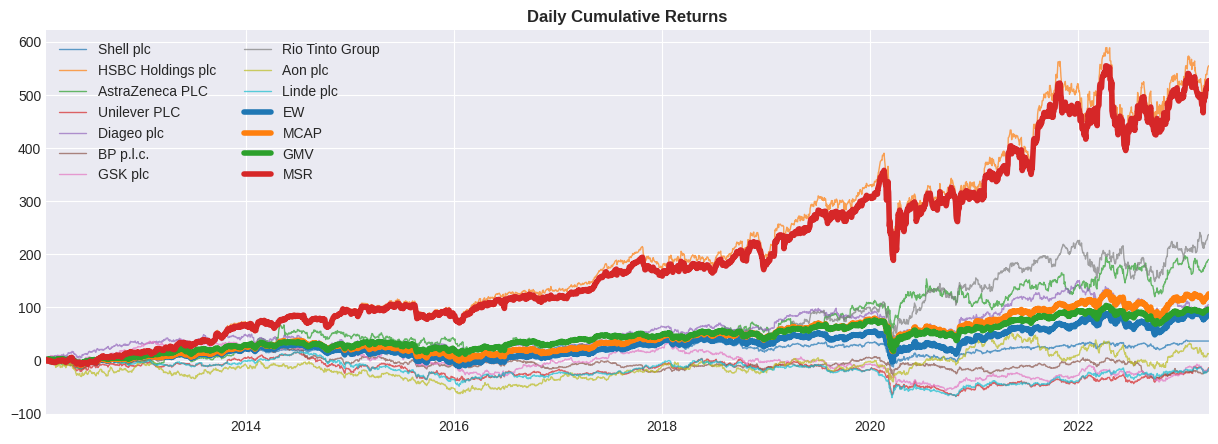

In [51]:
# Comparison of cumulative returns of individual assets and optimized portfolios

cum_returns = ((1 + stock_returns).cumprod() - 1)*100

fig = plt.figure(figsize=(15,5))
colors=['r', 'g', 'b']
for x in cum_returns:
        if x in cum_returns.columns[:-4]:
                plt.plot(cum_returns.index, cum_returns[x], marker='',
                linewidth=1, alpha=0.7, label=x)
        else:
                plt.plot(cum_returns.index, cum_returns[x], marker='',
                        linewidth=4, alpha=1, label=x)
plt.title('Daily Cumulative Returns', weight='bold')
plt.legend(loc='upper left', ncol=2)
plt.margins(x=0)
plt.show()

The Annualized Sharpe Ratio is a measure of risk-adjusted performance of an investment or portfolio, calculated on an annual basis. It is obtained by dividing the annualized excess return (i.e., the expected annual return minus the risk-free rate) by the annualized standard deviation of returns. 

Reminder: **the Sharpe Ratio** is commonly used to assess the efficiency of an investment in generating returns per unit of risk taken, with a higher value indicating better risk-adjusted performance.

Text(0.5, 1.0, 'Annualized Sharpe Ratios')

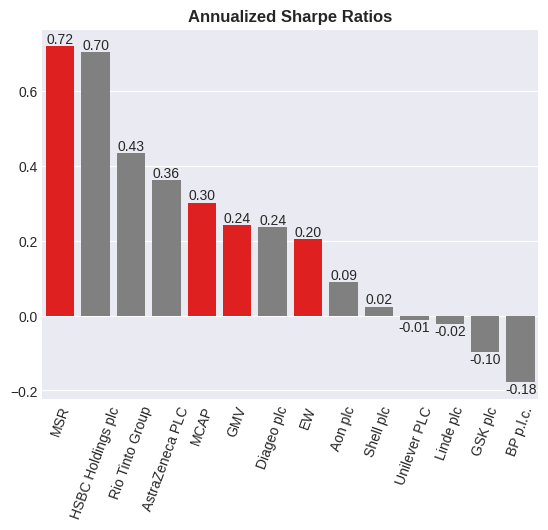

In [52]:
# Annualized Sharpe Ratios
sharpe = (stock_returns.mean()*252-rf) / (stock_returns.std()*np.sqrt(252))
sharpe = sharpe.sort_values(ascending=False)

palette = ['red' if (x=='MSR' or x=='GMV' or x=='MCAP' or x=='EW') else 'grey' for x in sharpe.index]
ax = sns.barplot(x=sharpe.index, y=sharpe.values, palette=palette)
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Annualized Sharpe Ratios', weight='bold')

#### Rolling statistics

The Rolling Annualized Standard Deviation, with a 60-day window, is a measure of the volatility or variability of returns of an investment or portfolio calculated over a rolling window of 60 days, and then annualized to facilitate comparison with other time periods. It is a common method used to assess the variability of returns over time and to capture changes in risk over different market conditions. The rolling standard deviation is calculated for each overlapping 60-day window, and then annualized by multiplying by the square root of the number of periods in a year (e.g., 252 trading days for daily data) to obtain a measure of the annualized volatility of returns for that specific window. This allows for monitoring of changes in volatility over time, providing insights into the historical risk profile of the investment or portfolio.

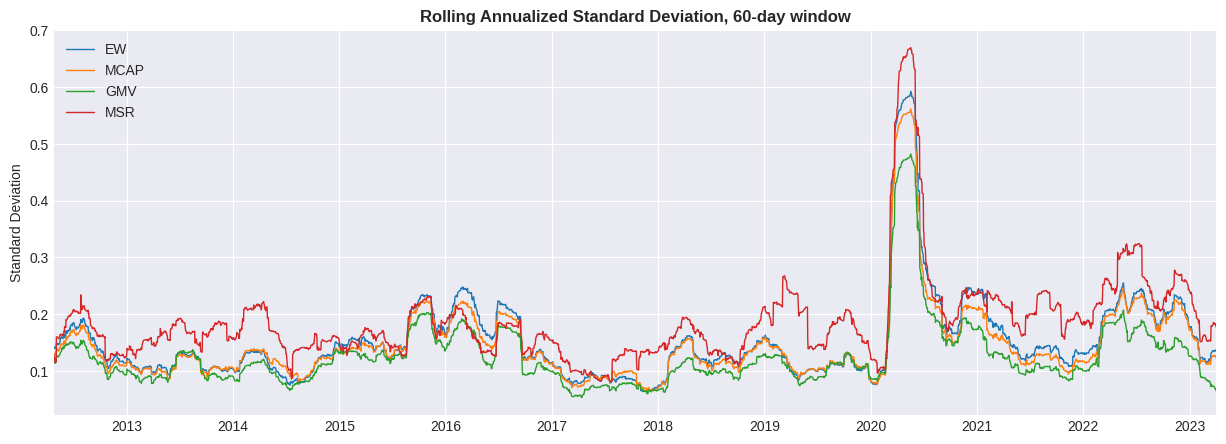

In [53]:
# Portfolios' volatility over time
port_vol = portfolio_returns.rolling(60).std().dropna()*np.sqrt(252) # 30-day rolling window
port_vol = port_vol.dropna()

# Plotting rolling annualized standard deviation
line_plot(data=port_vol, legend_loc='upper left', legend_ncol=1,
            title='Rolling Annualized Standard Deviation, 60-day window',
            ylabel='Standard Deviation')

Rolling Betas, with a 60-day window, refer to the calculation of beta coefficients for an investment or portfolio over a rolling window of 60 days. Beta is a measure of the sensitivity of an investment's returns to changes in the overall market or benchmark. A beta of 1 indicates that the investment's returns move in line with the market, while a beta greater than 1 indicates higher sensitivity, and a beta less than 1 indicates lower sensitivity.

The rolling beta is calculated by regressing the returns of the investment or portfolio against the returns of the market or benchmark for each overlapping 60-day window. This results in a series of beta coefficients, with one beta calculated for each window. By using a rolling window, the beta is calculated over a moving time period, allowing for monitoring of changes in the sensitivity of the investment or portfolio to market movements over time. The use of a 60-day window means that the beta is recalculated every 60 days, capturing changes in the investment's sensitivity to market movements over that specific time period. This can provide insights into the historical relationship between the investment or portfolio and the market, and how it may have changed over time.

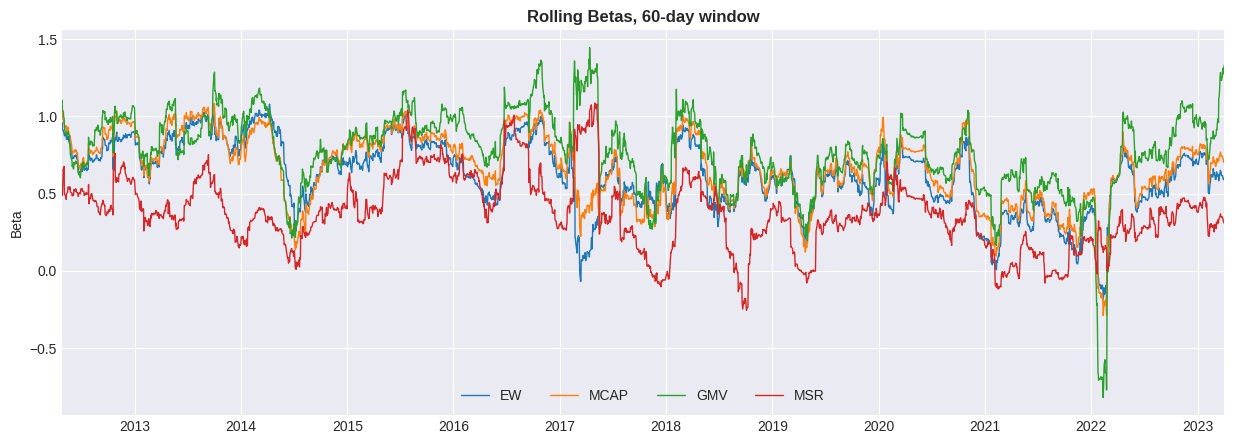

In [54]:
# Rolling betas
covariance = portfolio_returns.rolling(60).cov(market_returns)
variance = portfolio_returns.rolling(60).var()
rolling_beta = covariance.div(variance)
rolling_beta = rolling_beta.dropna()

# Plotting portfolio Betas
line_plot(data=rolling_beta, legend_loc='lower center', legend_ncol=4,
            title='Rolling Betas, 60-day window', ylabel='Beta')

**Exponentially Weighted Average** (EWA) with a 60-day half-life is a statistical method used to calculate the average of a series of values, giving more weight to recent values while progressively decreasing the weight of older values. The half-life represents the time period it takes for the weight of a value to decrease by half in the calculation.

In the context of a 60-day half-life, the EWA calculation would assign a weight of 50% to the most recent value, and the weight would decrease by half (to 25%) for each 60-day interval going back in time. This means that more recent values have a higher influence on the EWA calculation compared to older values, with the weight of each value decaying exponentially as it moves further back in time.

EWA with a 60-day half-life is commonly used in financial analysis and time-series data analysis to calculate moving averages or estimate trends in data, where recent values are considered more relevant than older values. The choice of half-life determines the rate at which older values lose their influence in the calculation, with smaller half-life values resulting in a faster decay of older values, and larger half-life values resulting in a slower decay.

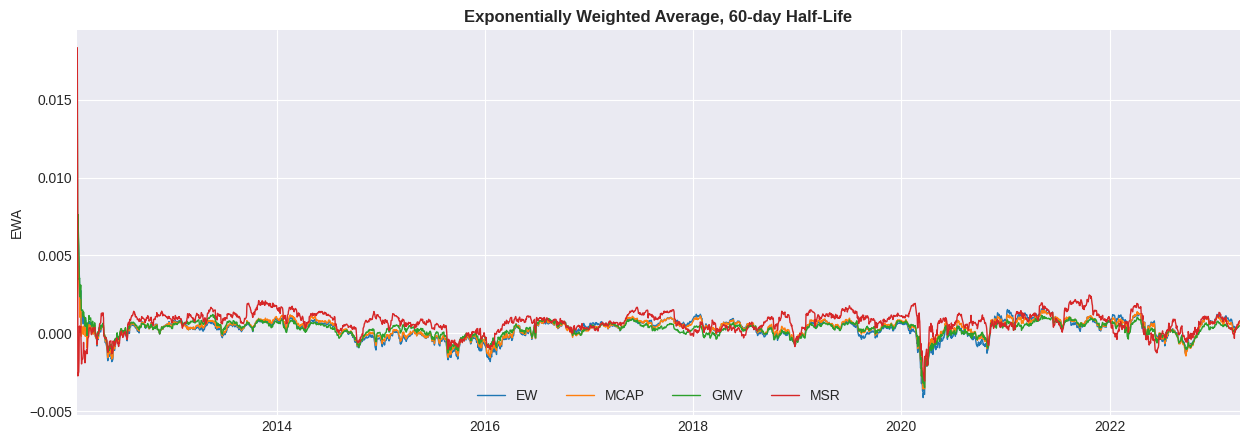

In [55]:
# Exponentially Weighted Average
ewa = portfolio_returns.ewm(halflife=60).mean()

line_plot(data=ewa, legend_loc='lower center', legend_ncol=4,
            title='Exponentially Weighted Average, 60-day Half-Life',
            ylabel='EWA')

**The Annualized Rolling Sharpe Ratio** is a financial metric that measures the risk-adjusted performance of an investment or portfolio over a specified time period, typically expressed as a ratio. It is calculated by dividing the annualized excess return (i.e., the difference between the annualized return and a risk-free rate) by the annualized rolling standard deviation of returns.

When calculated over a 12-month period, the Annualized Rolling Sharpe Ratio would measure the risk-adjusted performance of an investment or portfolio over the past year, taking into account both the returns and the volatility of the investment or portfolio during that period. The rolling approach involves recalculating the Sharpe Ratio at regular intervals (e.g., monthly, quarterly) using a sliding window that moves forward in time, incorporating the most recent 12 months of data.

The Annualized Rolling Sharpe Ratio is a widely used performance measure in finance and investment analysis as it provides insights into how well an investment or portfolio has performed relative to the risk taken over a specific time period, accounting for both returns and volatility. A higher Annualized Rolling Sharpe Ratio generally indicates better risk-adjusted performance, while a lower ratio may suggest higher risk or lower returns relative to the risk taken.

<Figure size 1500x500 with 0 Axes>

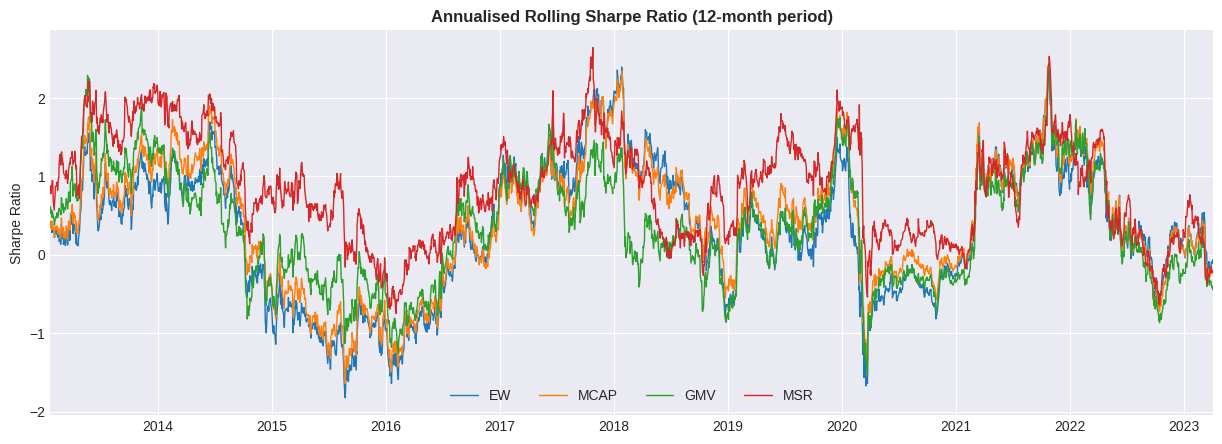

In [56]:
# Annualized Rolling Sharpe Ratio (12 month window)
rolling_sr = portfolio_returns.rolling(252).apply(lambda x: ((x.mean()*252)-rf)/(x.std()*np.sqrt(252)), raw=True)
rolling_sr = rolling_sr.dropna()

plt.figure(figsize=(15,5))
line_plot(data=rolling_sr, legend_loc='lower center', legend_ncol=4,
            title='Annualised Rolling Sharpe Ratio (12-month period)',
            ylabel='Sharpe Ratio')

* The use of rolling estimates provides us with a more comprehensive view of risk-adjusted returns compared to single point estimates for the entire period. This allows us to infer whether the risk-adjusted returns are consistent over time or if they fluctuate significantly.
* As evident from the data, the MSR exhibit volatility, indicating that the portfolios may be riskier at certain time points or periods.

#### **4. Tail Risk Analysis**
Tail risk includes low-probability events occurring at both ends of the normal distribution curve, also known as tail events.

##### **4.1 Historical Drawdown**

Historical drawdown refers to the maximum loss in value experienced by an investment or portfolio during a specific historical period, typically expressed as a percentage from the peak value to the trough value. It provides insights into the historical downside risk or losses that an investment or portfolio has experienced in the past. Historical drawdowns are commonly used in finance to assess the historical performance and risk of an investment or portfolio, and can help investors make informed decisions about their investment strategies and risk tolerance.

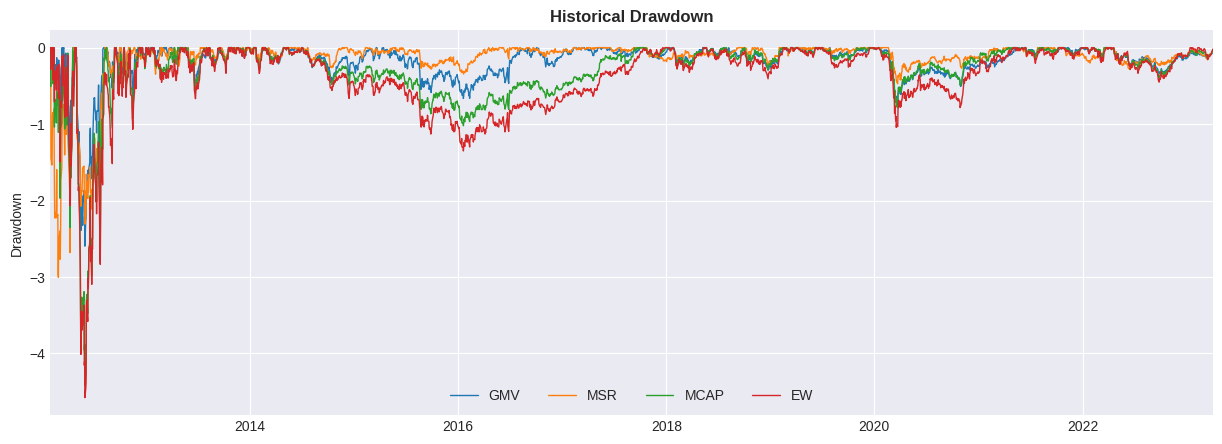

In [57]:
# Historical drawdown
running_max = np.maximum.accumulate(cum_returns[['GMV','MSR','MCAP','EW']])
drawdown = (cum_returns[['GMV','MSR','MCAP','EW']])/running_max - 1
drawdown[drawdown > 0] = 0 # because we only care about losses

line_plot(data=drawdown, legend_loc='lower center', legend_ncol=4,
            title='Historical Drawdown',
            ylabel='Drawdown')

Equally-weighted portfolio (EW) had slightly stronger drawdowns over the period.

A historical drawdown line plot typically displays the drawdowns of an investment or portfolio over a specific time period. Here are some key points to consider when interpreting a historical drawdown line plot:

* Drawdown Magnitude: The magnitude of the drawdown is represented by the depth of the line plot, with deeper drawdowns indicating larger losses in value. The lower the line goes on the plot, the greater the magnitude of the historical drawdown.

* Duration of Drawdown: The duration of the drawdown is represented by the length of the line plot, with longer line segments indicating longer periods of time during which the investment or portfolio experienced losses. The longer the line extends horizontally on the plot, the longer the duration of the historical drawdown.

* Recovery Periods: The historical drawdown line plot may also show recovery periods, where the line starts to move upward, indicating that the investment or portfolio has regained its losses and is moving towards its previous peak value. Recovery periods can provide insights into the historical resilience and potential for rebound of the investment or portfolio.

* Trend and Patterns: The overall trend and patterns of the historical drawdown line plot can provide insights into the investment or portfolio's performance and risk characteristics. For example, if the line plot shows frequent and deep drawdowns with slow recovery periods, it may indicate a higher level of risk and potential for significant losses. On the other hand, if the line plot shows shallow drawdowns with quick recovery periods, it may indicate a lower level of risk and faster rebound potential.

* Comparison to Benchmarks: It can be useful to compare the historical drawdowns of the investment or portfolio to relevant benchmarks or industry standards to assess its relative performance and risk. If the investment or portfolio's historical drawdowns are consistently worse than the benchmarks, it may indicate underperformance and higher risk.

##### **4.2 Value at Risk (VaR) and Conditional Value at Risk (CVaR)**

In this section, we will discuss statistical methods for evaluating economic losses and managing market risk exposure. These methods include:

* Value at Risk (VaR): VaR utilizes historical portfolio returns to estimate the maximum potential losses that could occur in a portfolio at a given likelihood level, considering a specific time horizon. It represents a worst-case scenario loss associated with a probability and time period.

* CVaR (Conditional Value at Risk or Expected Shortfall): CVaR goes beyond VaR by considering the expected loss if the worst-case threshold is breached. It accounts for the expected losses that may occur beyond the VaR breakpoint, providing a more comprehensive measure of portfolio risk.

##### **Historical (Non-Parametric) Method**
In this straightforward and efficient approach, we calculate VaR and CVaR directly from historical returns without making any assumptions about the distribution of the data. It involves ordering the historical returns from worst to best, allowing us to estimate the maximum potential losses (VaR) and expected losses beyond the worst-case threshold (CVaR) based on real historical data.

Max historical daily loss (95) - EW: 9.94%
Max historical daily loss (95) - MCAP: 9.45%
Max historical daily loss (95) - GMV: 9.16%
Max historical daily loss (95) - MSR: 15.49%


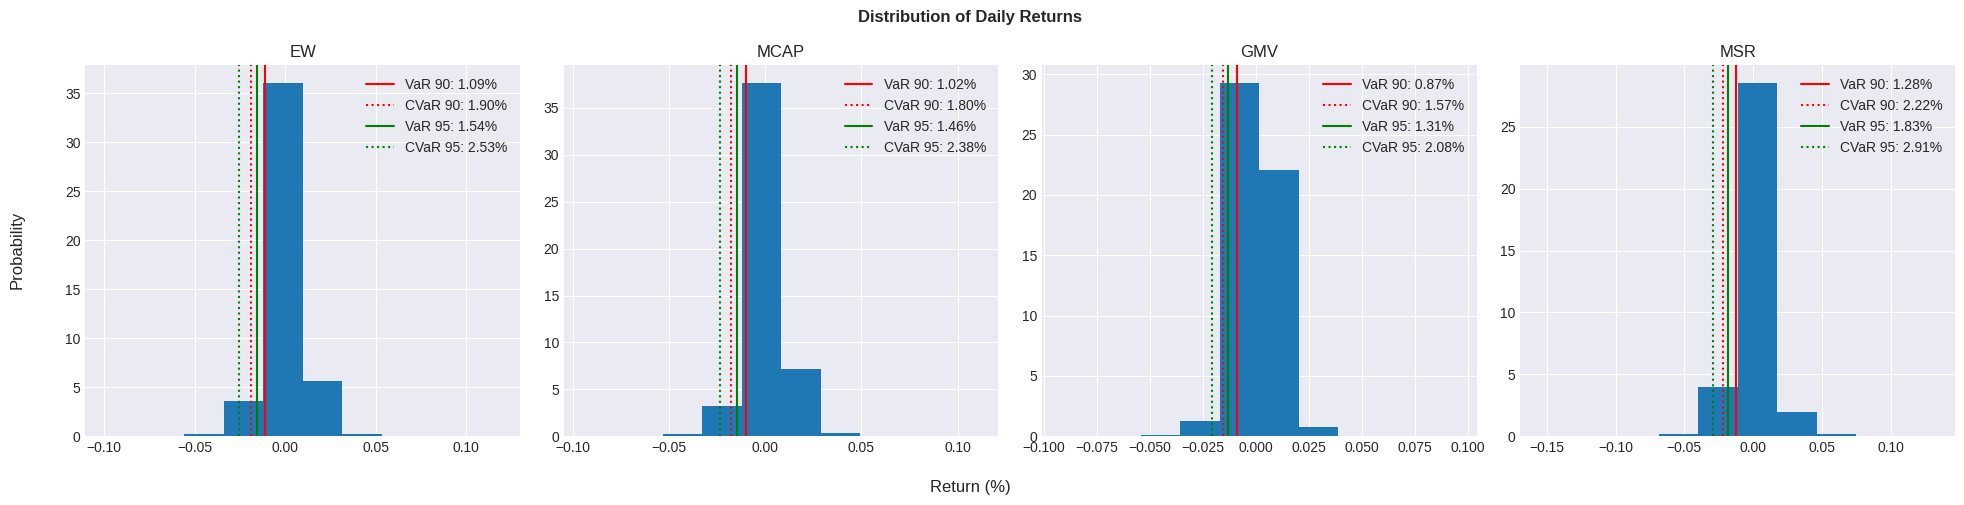

In [58]:
portfolios = portfolio_returns.columns
fig = plt.figure(figsize=(20,5))
var_H_port = []
cvar_H_port = []
for portfolio,num in zip(portfolios,range(4)):
    portfolio_ret = portfolio_returns[portfolio]
    # Sorting the returns for plotting
    portfolio_ret = portfolio_ret.sort_values()
    plt.subplot(1,4,num+1)
    # Plot the probability of each return quantile
    plt.hist(portfolio_ret, density=True)
    # HS VaR and CVaR 90,95,99
    var_levels = [90,95]
    colors = ['r','g']
    for var_level,color in zip(var_levels,colors):
        var_H = np.percentile(portfolio_ret, 100-var_level)
        plt.axvline(x=var_H, color=color, linestyle="-", label=f'VaR {var_level}: {-var_H*100:.2f}%')
        cvar_H = portfolio_ret[portfolio_ret <= var_H].mean()
        cvar_H_port.append(cvar_H)
        plt.axvline(x=cvar_H, color=color, linestyle=":", label=f'CVaR {var_level}: {-cvar_H*100:.2f}%')
        plt.title(f'{portfolio}')
        plt.legend(loc='upper right',frameon=False)
    plt.suptitle('Distribution of Daily Returns', weight='bold')
    fig.supylabel('Probability'), fig.supxlabel('Return (%)')
    plt.tight_layout(rect=(0.025,0,1,1))
    # Calculating maximum historical daily loss
    var_H = np.percentile(portfolio_ret, 100-95)
    cvar_95_H_min = portfolio_ret[portfolio_ret <= var_H].min()
    print(f'Max historical daily loss (95) - {portfolio}: {-cvar_95_H_min*100:.2f}%')

Let's analyze VaR(95) and identify the smallest value, which corresponds to GMV portfolio. VaR(95) for GMV portfolio implies that there is a 95% confidence level that losses will not exceed 1.31% in a single day. But what about losses that exceed this threshold? CVaR(95) provides further insights, indicating that on average, in the worst 5% of cases, GMV portfolio's daily losses will be 2.08%, with a maximum value of 9.16%.


##### **VaR over n-day time period**
To calculate VaR over a longer time window, we can multiply our 1-day VaR estimate by the square root of the desired time period. This allows us to extend our VaR estimation beyond a single day to cover a longer time period.

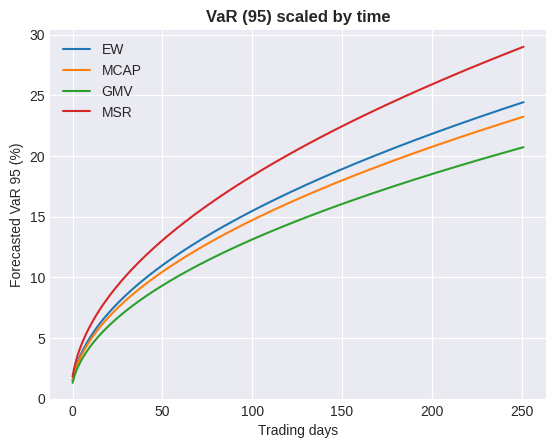

In [59]:
# Aggregate forecasted VaR
forecasted_val = np.empty([252, 2]) 

# Loop through each forecast period
data=[]
for portfolio in portfolios:
    forecasted_val = np.empty([252, 2])
    portfolio_ret = portfolio_returns[portfolio]
    portfolio_ret = portfolio_ret.sort_values()
    for i in range(0,252):
        # Save the time horizon i
        forecasted_val[i, 0] = i
        # Save the forecasted VaR 95
        forecasted_val[i, 1] = np.percentile(portfolio_ret, 100-95) * np.sqrt(i+1)
    # Data for plotting
    x = forecasted_val[:,0]
    y = forecasted_val[:,1]*(-100)
    plt.plot(x,y, label=portfolio)
plt.title('VaR (95) scaled by time', weight='bold')
plt.ylabel('Forecasted VaR 95 (%)'), plt.xlabel('Trading days')
plt.legend(loc=0, frameon=False)
plt.show()

##### **Parametric (Variance-Covariance) Method**
This method assumes a normal distribution of returns, which simplifies our estimation to just two factors: the expected return and the standard deviation. This enables us to plot a normal distribution curve and make calculations based on this assumption.

In [60]:
from scipy.stats import norm
# Normal distribution assumption
def parametric_var(portfolio,alpha):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    return mu - norm.ppf(alpha)*std

def parametric_cvar(portfolio,alpha):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    return mu + alpha**-1 * norm.pdf(norm.ppf(alpha))*std

var_p_table = pd.DataFrame()
for portfolio in portfolios:
    var_p = parametric_var(portfolio,0.05)
    cvar_p = parametric_cvar(portfolio,0.05)
    var_p_table_temp = pd.DataFrame({'Parametric VaR (95)':var_p,'Parametric CVaR (95)':cvar_p}, 
                                    index=[portfolio])
    for col in var_p_table_temp[-2:]:
        var_p_table_temp[col] = var_p_table_temp[col].apply(lambda x: "{:.2f}%".format(x*100))
    var_p_table = pd.concat((var_p_table,var_p_table_temp))
var_p_table

Parametric VaR (95) Parametric CVaR (95)
EW                 1.79%                2.24%
MCAP               1.70%                2.13%
GMV                1.46%                1.83%
MSR                2.17%                2.71%

##### **Monte Carlo Method**

Monte Carlo Simulation and Historical Simulation both estimate Value at Risk (VaR) by simulating scenarios of risk factors and revaluing the portfolio for each trial. However, they use different methods to generate the risk factor scenarios. Monte Carlo Simulation uses a lognormal distribution, while Historical Simulation relies on historical data.

Although both models assume the same distribution for risk factors, the approach for generating the price distribution of the assets differs. In Monte Carlo Simulation, the change in value for each scenario is calculated, and the worst losses are examined to estimate VaR.

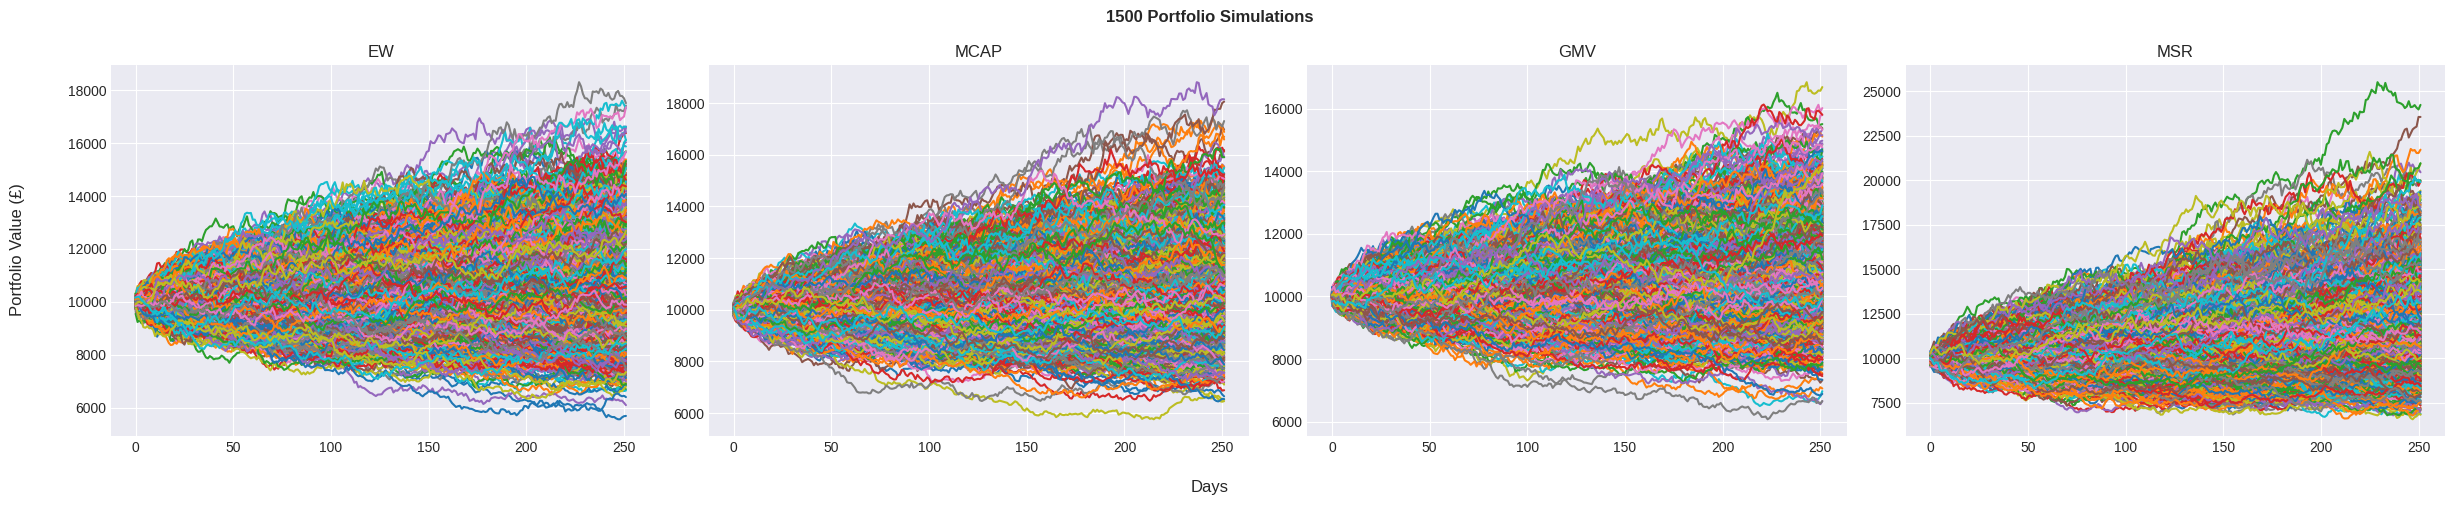

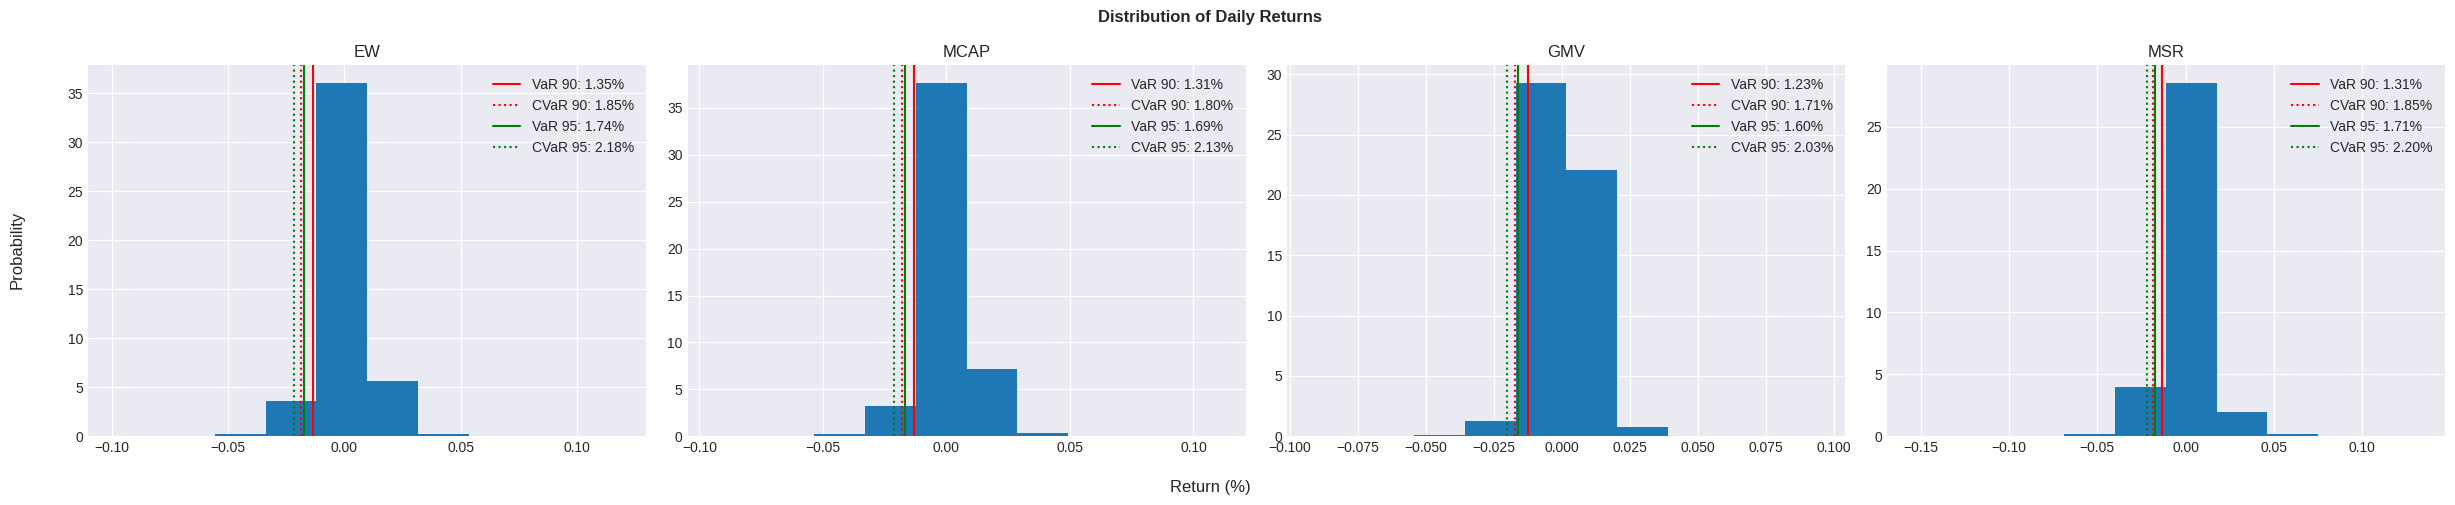

In [61]:
trading_days = 252 # forecast period
S0 = 10000 # initial portfolio value
simulations_number = 1500 # number of simulations
sim_returns = []
fig_0 = plt.figure(0,figsize=(25,5))
fig_1 = plt.figure(1,figsize=(25,5))
colors = ['r','g']
var_levels = [90,95]
for portfolio,num in zip(portfolios,range(4)):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    # Loop through 100 simulations
    plt.figure(0)
    for i in range(simulations_number):
        random_rets = np.random.normal(mu, std, trading_days)   
        forecasted_values = S0*(random_rets+1).cumprod()-1
        sim_returns.append(random_rets)
        # Show the simulations
        plt.subplot(1,4,num+1)
        plt.plot(range(trading_days), forecasted_values)
        plt.title(f'{portfolio}')
    plt.suptitle('1500 Portfolio Simulations', weight='bold')
    fig_0.supylabel('Portfolio Value (£)'), fig_0.supxlabel('Days')
    plt.tight_layout(rect=(0.025,0,1,1))
    # Returns distribution
    plt.figure(1)
    plt.subplot(1,4,num+1)
    plt.hist(portfolio_ret, density=True)
    for var_level,color in zip(var_levels,colors):
        var_mc = np.percentile(sim_returns, 100-var_level)
        cvar_mc = np.array(sim_returns)[np.array(sim_returns) <= var_mc].mean()
        plt.axvline(x=var_mc, color=color, linestyle="-", 
                    label=f'VaR {var_level}: {-var_mc*100:.2f}%')
        plt.axvline(x=cvar_mc, color=color, linestyle=":",
                    label=f'CVaR {var_level}: {-cvar_mc*100:.2f}%')
        plt.title(f'{portfolio}')
        plt.legend(loc='upper right',frameon=False)
    plt.suptitle('Distribution of Daily Returns', weight='bold')
    fig_1.supylabel('Probability'), fig_1.supxlabel('Return (%)')
    plt.tight_layout(rect=(0.025,0,1,1))

##### **Expected losses of our investment portfolio**
95% Value at Risk of 10,000 (money) investment in each portfolio over different time frames

In [63]:
from scipy.stats import norm
def var(method,portfolio, investment, time_frame, confidence_level):
    # time horizon of VaR
    if time_frame == 'day':
        days = 1
    elif time_frame == 'month':
        days = 21
    elif time_frame == 'quarter':
        days = 63
    elif time_frame == 'year':
        days = 252
    else:
        raise ValueError ('time_frame input invalid.')
    
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)

    # Var estimation method
    if method=='parametric':
        alpha = (100-confidence_level)/100
        var = investment*(mu-norm.ppf(alpha)*std)*np.sqrt(days)
        return var
    elif method=='historical':
        portfolio_ret = portfolio_ret.sort_values()
        var = investment*(-np.percentile(portfolio_ret, 100-confidence_level)*np.sqrt(days))
        return var
    elif method=='monte carlo':
        for i in range(1500):
            random_rets = np.random.normal(mu, std, 252)
            forecasted_values = 10*(random_rets+1).cumprod()-1
            sim_returns.append(random_rets)
        var = investment*(-np.percentile(sim_returns, 100-confidence_level)*np.sqrt(days))
        return var
    else:
        raise ValueError ('method input invalid')

var_table = pd.DataFrame()
methods = ['historical','parametric','monte carlo']
for method in methods:
    for portfolio in portfolios:
        # Portfolio VaR calculation for each time horizon:
        var_p_d = var(method=method, portfolio=portfolio,investment = 10000, time_frame='day',
                    confidence_level=95)
        var_p_m = var(method=method, portfolio=portfolio, investment = 10000, time_frame='month',
                    confidence_level=95)
        var_p_q = var(method=method, portfolio=portfolio, investment = 10000, time_frame='quarter',
                    confidence_level=95)
        var_p_y = var(method=method, portfolio=portfolio, investment = 10000, time_frame='year',
                    confidence_level=95)
        var_table_temp = pd.DataFrame({'Method':method,'Daily':[var_p_d],'Monthly':[var_p_m], 
                                        'Quarterly':[var_p_q], 'Annual':[var_p_y]}, index=[portfolio])
        # Format numbers as currency
        for col in var_table_temp.columns[-4:]:
            var_table_temp[col]= var_table_temp[col].apply(lambda x: "{:,.1f}".format(x))
        var_table = pd.concat([var_table,var_table_temp])
var_table

Method  Daily Monthly Quarterly   Annual
EW     historical  153.9   705.2   1,221.4  2,442.8
MCAP   historical  146.3   670.5   1,161.4  2,322.8
GMV    historical  130.5   598.1   1,035.9  2,071.8
MSR    historical  182.6   836.9   1,449.6  2,899.2
EW     parametric  179.1   820.5   1,421.2  2,842.4
MCAP   parametric  170.4   781.0   1,352.7  2,705.4
GMV    parametric  146.3   670.3   1,161.0  2,322.1
MSR    parametric  217.4   996.4   1,725.8  3,451.6
EW    monte carlo  171.3   785.3   1,360.8  2,723.4
MCAP  monte carlo  171.2   783.3   1,354.4  2,704.7
GMV   monte carlo  169.4   772.3   1,330.8  2,649.1
MSR   monte carlo  168.0   774.9   1,350.5  2,716.2

We again look at MSR.

* Using the Monte Carlo method, we can estimate that with 95% confidence level, the losses from a 10,000 investment in the MSR portfolio will not exceed $774.9 in a given month.
* In comparison, both the Historical and Parametric approaches estimate a higher Value at Risk (VaR) than the Monte Carlo method.
* At the same time, there is minimal disparity in values when employing the Monte Carlo Simulation approach.